<a href="https://colab.research.google.com/github/Larasitradini/ADDP/blob/main/ICDLARAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Laras Itra Dini

In [1]:
! pip install kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d muratkokludataset/pistachio-image-dataset

 71% 19.0M/26.7M [00:00<00:00, 103MB/s] 
100% 26.7M/26.7M [00:00<00:00, 102MB/s]


In [5]:
import os, zipfile

In [6]:
zipPath = '../content/pistachio-image-dataset.zip'
zipFile = zipfile.ZipFile(zipPath, 'r')
zipFile.extractall('../content/PistachioDataset/')
zipFile.close()

In [7]:
FILE_PATH = '../content/PistachioDataset/Pistachio_Image_Dataset/'

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
BATCH_SIZE = 32

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

train_generator = train_datagen.flow_from_directory(
    FILE_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    FILE_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='validation'
)

Found 1719 images belonging to 3 classes.
Found 429 images belonging to 3 classes.


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization


In [49]:
model = Sequential([
    Conv2D(filters = 16, kernel_size = (3, 3), padding = 'Same', activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.4),
    BatchNormalization(),

    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    Dropout(0.2),

    Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(3, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])


In [50]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [51]:
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [52]:
class TargetCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95):
      print("\nAccuracy and Validation Accuracy has reached 95%!\nStop Train!")
      self.model.stop_training = True
Target = TargetCallback()

EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.0001,
    patience = 3,
    verbose = 1,
    mode = 'auto'
)

In [53]:
History = model.fit(
    train_generator,
    epochs =  100,
    validation_data = val_generator,
    callbacks = [Target, EarlyStop],
    verbose = 1
)

Epoch 1/100
54/54 [==============================] - 31s 548ms/step - loss: 0.2165 - accuracy: 0.8313 - val_loss: 0.2839 - val_accuracy: 1.0000
Epoch 2/100
54/54 [==============================] - 30s 555ms/step - loss: 0.1557 - accuracy: 0.8778 - val_loss: 0.2417 - val_accuracy: 1.0000
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 1.0000
Accuracy and Validation Accuracy has reached 95%!
Stop Train!
54/54 [==============================] - 33s 606ms/step - loss: 0.1143 - accuracy: 1.0000 - val_loss: 2.2897e-07 - val_accuracy: 1.0000


In [54]:
import matplotlib.pyplot as plt

Loss with Val_Loss Graph


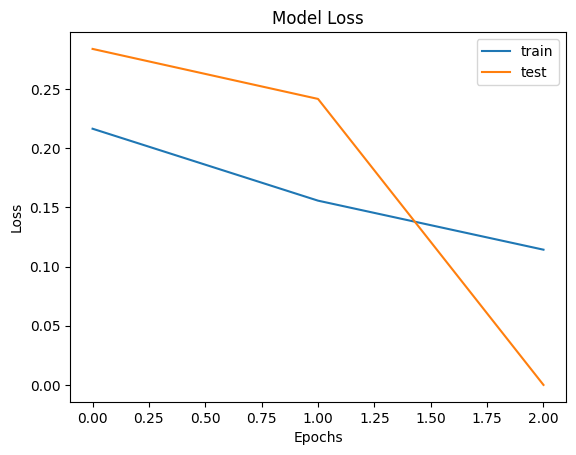

Acc with Val_Acc Graph


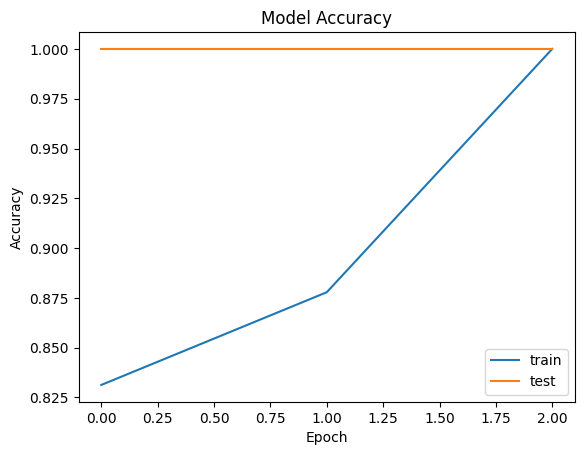

In [55]:
print("Loss with Val_Loss Graph")
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

print("Acc with Val_Acc Graph")
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


In [40]:
import tensorflow as tf
import pathlib

In [41]:

export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('PistachioModel.tflite')
tflite_model_file.write_bytes(tflite_model)

209936